In [2]:
!pip install catboost

     |████████████████████████████████| 65.8MB 62kB/s 


In [3]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
test = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/test.csv', 
                   dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

item_categories = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

items = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/items.csv',
                    dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})

shops = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

sales = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})


In [ ]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [1]:
sales

NameError: ignored

join data sets

In [5]:
train = pd.merge(sales, items, on='item_id')
train = pd.merge(train, item_categories, on='item_category_id')
train = pd.merge(train, shops, on='shop_id')

Let's take a look at the raw data

In [ ]:
print('train rows:', train.shape[0])
print('train columns:', train.shape[1])

train rows: 2935849
train columns: 10


In [ ]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-04-26 00:00:00,2013-06-26 00:00:00,2013-07-20 00:00:00,2013-09-14 00:00:00
date_block_num,0,3,5,6,8
shop_id,59,59,59,59,59
item_id,22154,944,944,944,944
item_price,999,150,199.5,199.5,299
item_cnt_day,1,1,1,1,2
item_name,ЯВЛЕНИЕ 2012 (BD),2012 (BD),2012 (BD),2012 (BD),2012 (BD)
item_category_id,37,37,37,37,37
item_category_name,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray
shop_name,"Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир"""


In [ ]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.916519e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726660e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


Time period of the dataset

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


Data leakages

In [6]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [ ]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


Data cleaning

In [7]:
train.query('item_price<=0')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2256678,2013-05-15,4,32,2973,-1.0,1,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


In [8]:
train = train.query('item_price>0')

Data prprocessing

In [35]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day' ]]
train_monthly

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.0,1
16,2015-07-21,30,59,37,21619,499.0,1
17,2013-08-01,0,59,37,21759,499.0,1
18,2013-06-28,5,59,37,21759,499.0,1
19,2014-04-11,22,59,37,21759,199.0,1
...,...,...,...,...,...,...,...
2935816,2015-09-13,32,55,26,5007,140.0,1
2935817,2015-09-16,32,55,26,5007,140.0,1
2935818,2015-10-16,33,55,26,5007,140.0,1
2935846,2015-09-16,32,55,36,13094,2500.0,1


In [36]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
#item_idごとに合計などを算出
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.000000,1532.857178,9,1.285714,7
1,0,2,2,5643,4775.209961,2387.604980,0,0.000000,2
2,0,2,5,5583,1188.300049,594.150024,2,1.000000,2
3,0,2,6,7893,5970.000000,1990.000000,3,1.000000,3
4,0,2,6,7894,1490.000000,1490.000000,1,1.000000,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.000000,4390.000000,1,1.000000,1
600155,33,59,79,17717,8025.500000,802.549988,13,1.300000,10
600156,33,59,83,22087,357.000000,119.000000,6,2.000000,3
600157,33,59,83,22088,238.000000,119.000000,2,1.000000,2


In [43]:
df = pd.DataFrame({'class':['A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B'],
                   'sex': ['F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'M'],
                   'num': [1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8],
                   'score':[12, 21, 4, 18, 19, 24, 27, 16, 20, 9, 25, 7, 14, 17, 26, 21]})
df

,class,sex,num,score
0,A,F,1,12
1,B,M,2,21
2,B,F,3,4
3,A,M,4,18
4,A,F,5,19
5,A,F,6,24
6,B,F,7,27
7,B,M,8,16
8,A,M,1,20
9,B,F,2,9


In [44]:
df = df.sort_values('class').groupby(['class', 'sex'], as_index=False)
df = df.agg({'num':['sum', 'mean'], 'score':['sum', 'mean','count']})
df

class sex num       score             
            sum  mean   sum   mean count
0     A   F  18  4.50    72  18.00     4
1     A   M  14  3.50    59  14.75     4
2     B   F  19  4.75    66  16.50     4
3     B   M  21  5.25    83  20.75     4

To mimic the real behavior of the data we have to create the missing records from the loaded dataset, so for each month we need to create the missing records for each shop and item, since we don't have data for them I'll replace them with 0.

In [ ]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []

for i in range(34):   #期間の月の合計数
  for shop in shop_ids:
    for item in item_ids:
      empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])
empty_df

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894
...,...,...,...
6734443,33,36,9103
6734444,33,36,9107
6734445,33,36,5704
6734446,33,36,12733


In [ ]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_monthly.fillna(0, inplace=True)
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0


New dataset

In [ ]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.0,0.0
shop_id,2.000000,2.000000,2.000000,2.0,2.0
item_id,5572.000000,5643.000000,5583.000000,7893.0,7894.0
item_category_id,2.000000,2.000000,5.000000,6.0,6.0
item_price,10730.000000,4775.209961,1188.300049,5970.0,1490.0
mean_item_price,1532.857178,2387.604980,594.150024,1990.0,1490.0
item_cnt,9.000000,0.000000,2.000000,3.0,1.0
mean_item_cnt,1.285714,0.000000,1.000000,1.0,1.0
transactions,7.000000,2.000000,2.000000,3.0,1.0


In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,33.00000
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,59.00000
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,22167.00000
item_category_id,6734448.0,3.786271,13.212956,0.0,0.00,0.0,0.00,83.00000
item_price,6734448.0,187.352417,2171.796631,0.0,0.00,0.0,0.00,515573.59375
mean_item_price,6734448.0,81.128105,531.164551,0.0,0.00,0.0,0.00,42990.00000
item_cnt,6734448.0,0.240223,3.456640,-4.0,0.00,0.0,0.00,2253.00000
mean_item_cnt,6734448.0,0.097299,0.612203,-2.0,0.00,0.0,0.00,1000.00000
transactions,6734448.0,0.181817,0.904735,0.0,0.00,0.0,0.00,31.00000


In [ ]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: (x//12 + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x%12))
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


##EDA

In [ ]:
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

How sales behaves along the year?

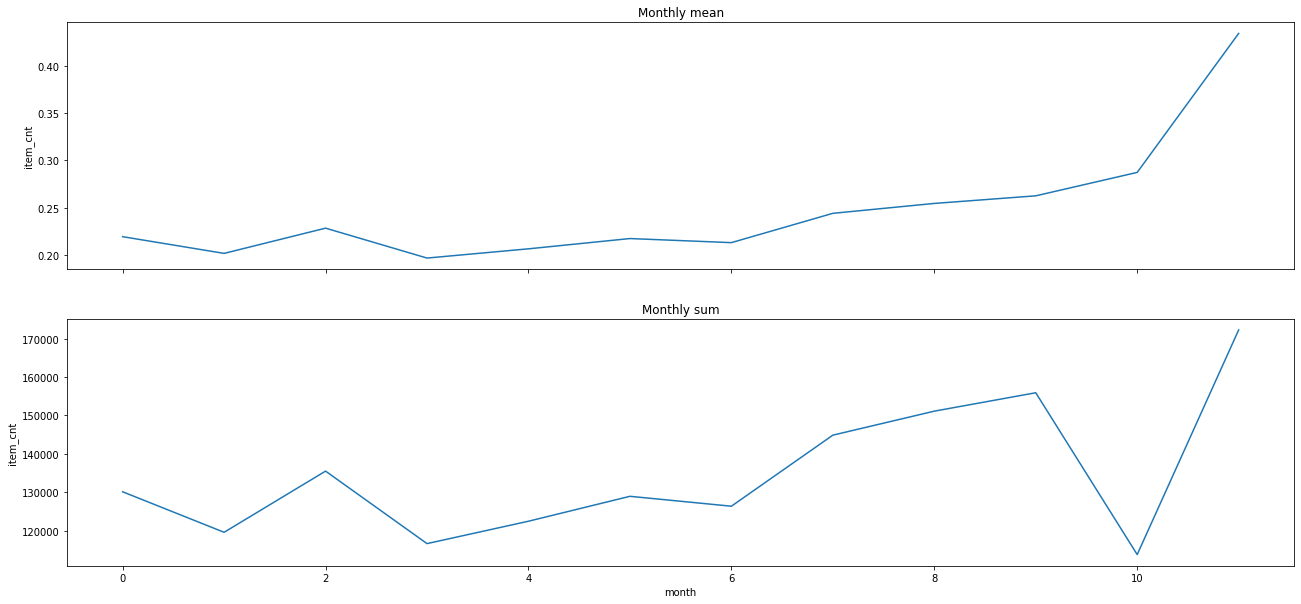

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22,10), sharex=True)
sns.lineplot(x='month', y='item_cnt', data=gp_month_mean, ax=axes[0]).set_title('Monthly mean')
sns.lineplot(x='month', y='item_cnt', data=gp_month_sum, ax=axes[1]).set_title('Monthly sum')
plt.show()

What category sells more?

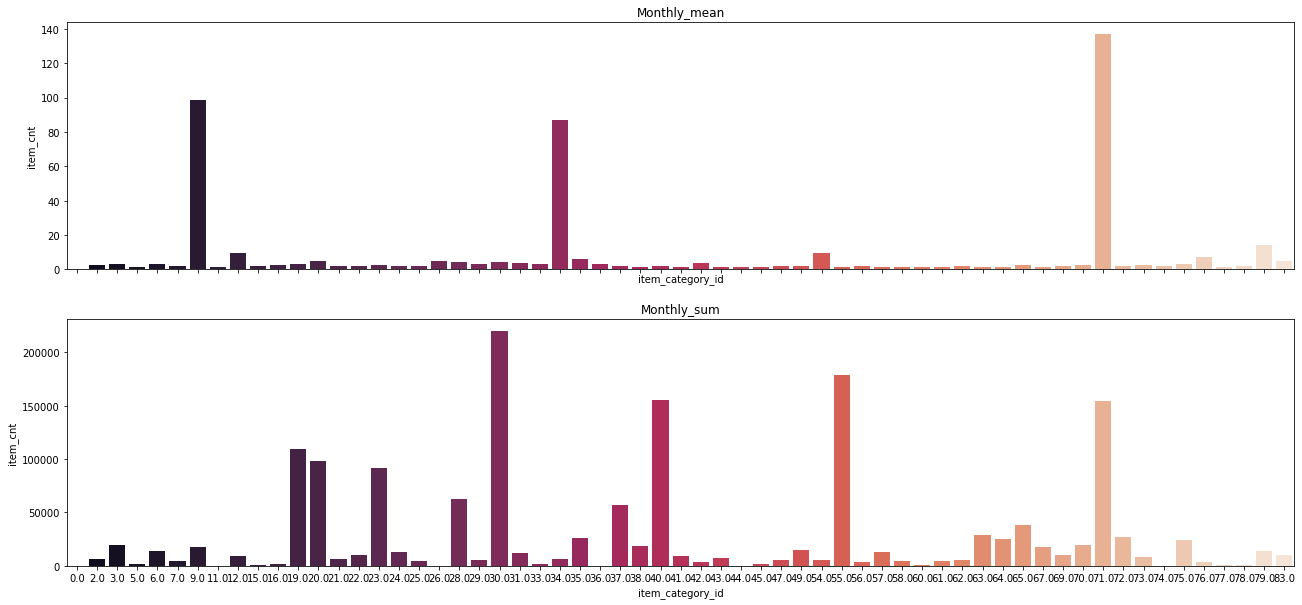

In [ ]:
f, axes = plt.subplots(2,1, figsize=(22,10), sharex=True)
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_mean, ax=axes[0], palette="rocket").set_title('Monthly_mean')
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_sum, ax=axes[1], palette="rocket").set_title('Monthly_sum')
plt.show()

What shop sells more?

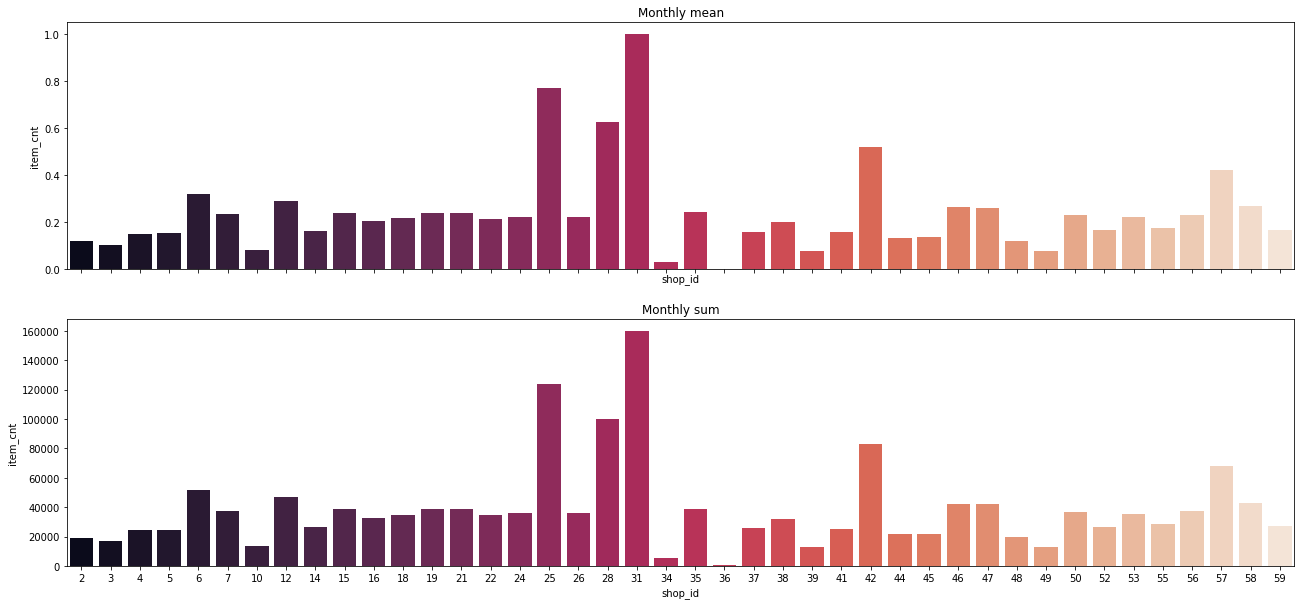

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

##Checking for outliers

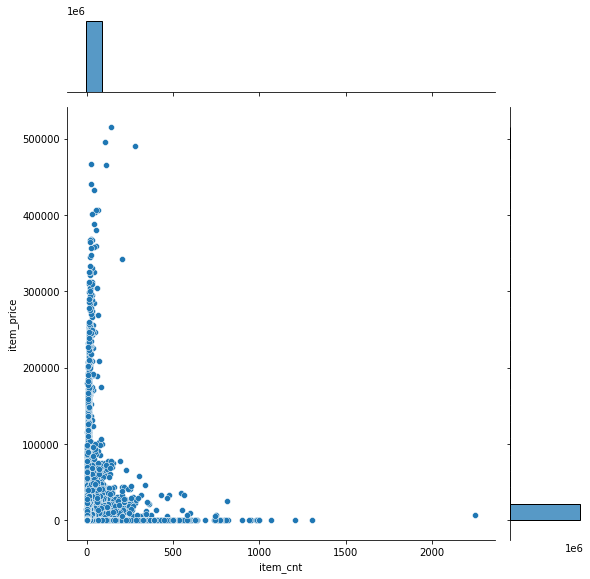

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

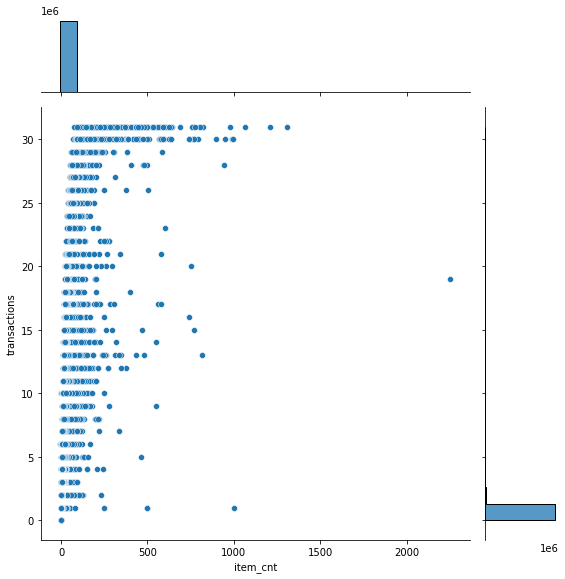

In [ ]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

##Feature 'item_cnt' distribution

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


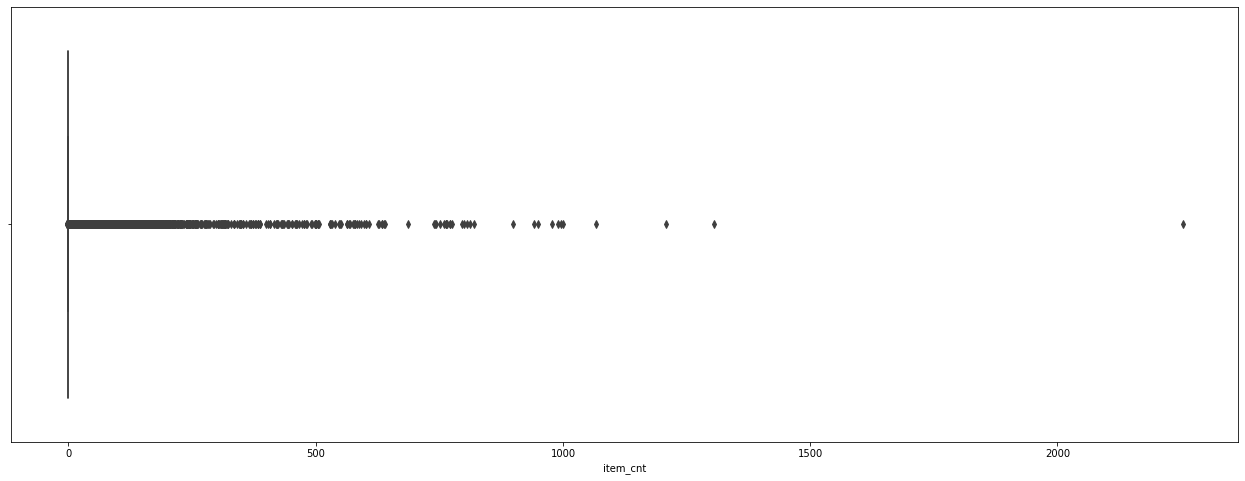

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

##Removing outliers

In [ ]:
train_monthly = train_monthly.loc[train_monthly['item_cnt']>=0].loc[train_monthly['item_cnt']<20].loc[train_monthly['item_price']<400000]
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
count,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06,6.727655e+06
mean,1.649870e+01,3.164337e+01,1.104307e+04,3.750449e+00,1.684426e+02,7.960112e+01,1.837896e-01,9.310856e-02,1.668584e-01,2.013941e+03,5.204959e+00
std,9.811489e+00,1.756363e+01,6.209681e+03,1.315351e+01,1.755220e+03,5.215818e+02,8.924671e-01,3.114655e-01,7.366312e-01,8.022785e-01,3.323066e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,0.000000e+00
25%,8.000000e+00,1.600000e+01,5.386000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,2.000000e+00
50%,1.600000e+01,3.500000e+01,1.126600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,5.000000e+00
75%,2.500000e+01,4.700000e+01,1.606800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03,8.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,8.300000e+01,3.648600e+05,4.299000e+04,1.900000e+01,1.900000e+01,1.800000e+01,2.015000e+03,1.100000e+01


##Creating the label

In [ ]:
train_monthly['item_cnt_nextmonth'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_nextmonth
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN


##Feature engineering

Unitary itme prices

In [ ]:
train_monthly['item_price_unit'] = train_monthly['item_price']//train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

Group based features
商品ごとの最大値最小値

In [ ]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

How much each item's price changed from its (lowest/highest) historical price.
商品ごとにその値段が最小値、最大値とどの程度離れているか

In [ ]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_increase'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

Rolling window based features (window= 3months)
店ごと、商品別の月ごと直前三ヶ月の最大値、最小値、平均値、標準偏差

In [ ]:
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(4):
  train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [ ]:
train_monthly.loc[train_monthly['shop_id']==2].loc[train_monthly['item_id']==5572]

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_nextmonth,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,8249.500000,9.0,9.0,9.000000,0.000000
197986,1,2,5572,2.0,1590.000000,1590.000000,1.0,1.000000,1.0,2013,1,1.0,1590.0,0.0,18979.5,17389.500000,1.0,9.0,5.000000,5.656854
395942,2,2,5572,2.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,2,2.0,1490.0,0.0,18979.5,17489.500000,1.0,9.0,3.666667,4.618802
593820,3,2,5572,2.0,2980.000000,1490.000000,2.0,1.000000,2.0,2013,3,2.0,1490.0,0.0,18979.5,15999.500000,1.0,2.0,1.333333,0.577350
791812,4,2,5572,2.0,2980.000000,1490.000000,2.0,1.000000,2.0,2013,4,2.0,1490.0,0.0,18979.5,15999.500000,1.0,2.0,1.666667,0.577350
989796,5,2,5572,2.0,2980.000000,1490.000000,2.0,1.000000,2.0,2013,5,1.0,1490.0,0.0,18979.5,15999.500000,2.0,2.0,2.000000,0.000000
1187740,6,2,5572,2.0,1590.000000,1590.000000,1.0,1.000000,1.0,2013,6,0.0,1590.0,0.0,18979.5,17389.500000,1.0,2.0,1.666667,0.577350
1385697,7,2,5572,0.0,0.000000,0.000000,0.0,0.000000,0.0,2013,7,0.0,0.0,0.0,18979.5,18979.500000,0.0,0.0,0.000000,0.000000
1583660,8,2,5572,0.0,0.000000,0.000000,0.0,0.000000,0.0,2013,8,2.0,0.0,0.0,18979.5,18979.500000,0.0,0.0,0.000000,0.000000
1781477,9,2,5572,2.0,3080.000000,1540.000000,2.0,1.000000,2.0,2013,9,0.0,1540.0,0.0,18979.5,15899.500000,1.0,2.0,1.666667,0.577350


Lag based features
店ごとにそれぞれの商品の１、２、３ヶ月前の売り上げ個数

In [ ]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

item sales count trend

In [ ]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
  ft_name = ('item_cnt_shifted%s' % lag)
  train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

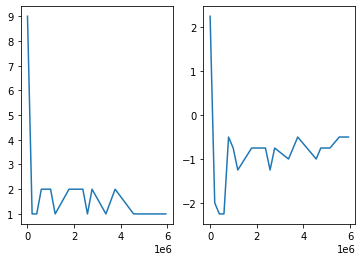

In [ ]:
f, ax = plt.subplots(1, 2)
item_id = 5572
shop_id = 2
item_category_id = 2
ax[0].plot(train_monthly.loc[train_monthly['shop_id']==shop_id].loc[train_monthly['item_id']==item_id].loc[train_monthly['item_category_id']==item_category_id]['item_cnt'])
ax[1].plot(train_monthly.loc[train_monthly['shop_id']==shop_id].loc[train_monthly['item_id']==item_id].loc[train_monthly['item_category_id']==item_category_id]['item_trend'])

Dataset after feature engineering

In [ ]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_nextmonth,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,8249.500000,9.0,9.0,9.0,0.0,0.0,0.0,0.0,2.25
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0,inf,0.0,35260.0,30484.789062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0,594.0,0.0,5592.0,4403.700195,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.50
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0,1990.0,0.0,27950.0,21980.000000,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.75
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0,1490.0,0.0,25880.0,24390.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.25


In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6727655.0,1.649870e+01,9.811489,0.0,8.0,16.0,25.0,3.300000e+01
shop_id,6727655.0,3.164337e+01,17.563632,2.0,16.0,35.0,47.0,5.900000e+01
item_id,6727655.0,1.104307e+04,6209.680558,30.0,5386.0,11266.0,16068.0,2.216700e+04
item_category_id,6727655.0,3.750449e+00,13.153510,0.0,0.0,0.0,0.0,8.300000e+01
item_price,6727655.0,1.684426e+02,1755.219727,0.0,0.0,0.0,0.0,3.648600e+05
mean_item_price,6727655.0,7.960112e+01,521.581848,0.0,0.0,0.0,0.0,4.299000e+04
item_cnt,6727655.0,1.837896e-01,0.892467,0.0,0.0,0.0,0.0,1.900000e+01
mean_item_cnt,6727655.0,9.310856e-02,0.311466,0.0,0.0,0.0,0.0,1.900000e+01
transactions,6727655.0,1.668584e-01,0.736631,0.0,0.0,0.0,0.0,1.800000e+01
year,6727655.0,2.013941e+03,0.802278,2013.0,2013.0,2014.0,2015.0,2.015000e+03


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
